<a href="https://colab.research.google.com/github/AarthiKalyanasundaram/RecommendationEngine/blob/master/MovieRecommendations_Using_Pycaret_and_SVD_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#import libraries
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pycaret

     |████████████████████████████████| 256kB 2.8MB/s 
     |████████████████████████████████| 65.9MB 57kB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 12.4MB 41.1MB/s 
     |████████████████████████████████| 1.6MB 35.7MB/s 
     |████████████████████████████████| 6.8MB 38.6MB/s 
     |████████████████████████████████| 1.2MB 44.6MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 266kB 48.6MB/s 
     |████████████████████████████████| 266kB 47.5MB/s 
     |████████████████████████████████| 2.1MB 40.7MB/s 
     |████████████████████████████████| 327kB 40.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 163kB 47.7MB/s 
     |████████████████████████████████| 153kB 51.7MB/s 
     |████████████████████████████████| 6.0MB 44.7MB/s 
     |████████████████████████████████| 1.1MB 38.3MB/s 
  Installing build dependencies ... done
  Getting req

In [61]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


In [62]:
#reading data using pandas 
from google.colab import files
uploaded = files.upload()
import io
movies = pd.read_csv(io.BytesIO(uploaded['movies.csv']))
ratings = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))

Saving movies.csv to movies (1).csv
Saving ratings.csv to ratings (1).csv


In [63]:
#analyzing the movies dataframe in order to understand the Dtypes, number of non null rows and number of columsn with this name by using info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [64]:
#Analyzing the movies dataframe like the how the data will look like
movies.head()

movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

In [65]:
#sorting the movies dataset
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)

In [66]:
#extract the year from the title column and add it as another column for analysis purpose
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year)
movies.year = movies.year.dt.year

In [67]:
#Removing the year from the title column
movies.title = movies.title.str[:-7]
movies

movieId  ...    year
0           1  ...  1995.0
1           2  ...  1995.0
2           3  ...  1995.0
3           4  ...  1995.0
4           5  ...  1995.0
...       ...  ...     ...
9737   193581  ...  2017.0
9738   193583  ...  2017.0
9739   193585  ...  2017.0
9740   193587  ...  2018.0
9741   193609  ...  1991.0

[9742 rows x 4 columns]

In [68]:
#Merging the movies dataframe and ratings dataframe using inner join with the help of merge
data = movies.merge(ratings, on='movieId',how="inner")
data.head()

movieId      title  ... rating   timestamp
0        1  Toy Story  ...    4.0   964982703
1        1  Toy Story  ...    4.0   847434962
2        1  Toy Story  ...    4.5  1106635946
3        1  Toy Story  ...    2.5  1510577970
4        1  Toy Story  ...    4.5  1305696483

[5 rows x 7 columns]

In [69]:
#converting the timestamp to datetime format 
data["timestamp"] = pd.to_datetime(data["timestamp"],unit="s")

In [70]:
data.head()

movieId      title  ... rating           timestamp
0        1  Toy Story  ...    4.0 2000-07-30 18:45:03
1        1  Toy Story  ...    4.0 1996-11-08 06:36:02
2        1  Toy Story  ...    4.5 2005-01-25 06:52:26
3        1  Toy Story  ...    2.5 2017-11-13 12:59:30
4        1  Toy Story  ...    4.5 2011-05-18 05:28:03

[5 rows x 7 columns]

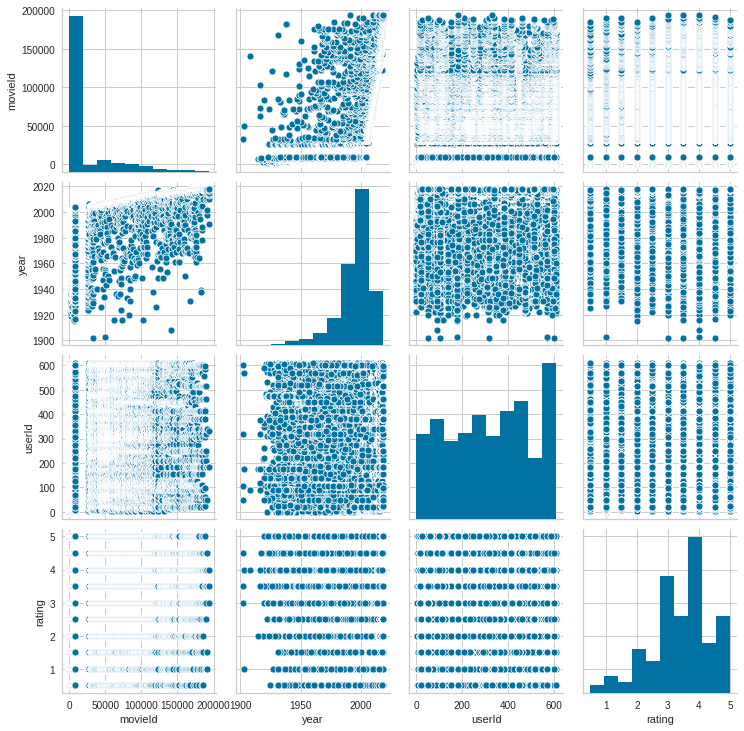

In [71]:
#creating a pairplot

import seaborn as sns

sns.pairplot(data)

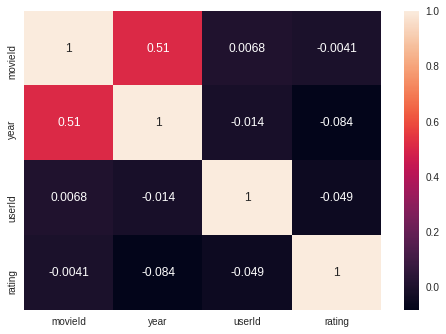

In [72]:
#To find out the correlation creating the heatmap

correlation = data.corr()
sns.heatmap(correlation,annot = True)

In [73]:
#dropping the columns the timestamp, title and genres since these are not relevant for predicting the ratings

data.drop(['timestamp','title','genres'], axis=1,inplace=True)

In [75]:
data.dropna(axis=0,how="any")

movieId    year  userId  rating
0             1  1995.0       1     4.0
1             1  1995.0       5     4.0
2             1  1995.0       7     4.5
3             1  1995.0      15     2.5
4             1  1995.0      17     4.5
...         ...     ...     ...     ...
100831   193581  2017.0     184     4.0
100832   193583  2017.0     184     3.5
100833   193585  2017.0     184     3.5
100834   193587  2018.0     184     3.5
100835   193609  1991.0     331     4.0

[100818 rows x 4 columns]

In [76]:
#Train test split 

finaldata = data.sample(frac=0.8, random_state=42).reset_index(drop=True)
data_unseen = data.drop(finaldata.index).reset_index(drop=True)

print('Data for Modeling: ' + str(finaldata.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (80669, 4)
Unseen Data For Predictions: (20167, 4)


In [77]:
#importing the pycaret

from pycaret.regression import *
reg = setup(data = finaldata, target = 'rating', session_id=1)

 
Setup Succesfully Completed.


In [42]:
compare_models()

In [78]:
model = create_model("xgboost")

In [79]:
tune_xgboost = tune_model(model)

In [80]:
#To evaluate the tuned model

evaluate_model(tune_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [81]:
predict_model(tune_xgboost);

Model     MAE     MSE  ...     R2   RMSLE    MAPE
0  Extreme Gradient Boosting Regressor  0.6854  0.8027  ...  0.263  0.2399  0.3017

[1 rows x 7 columns]

In [82]:
#finalizing the model

final_xgboost = finalize_model(tune_xgboost)

In [84]:
predict_model(final_xgboost)

Model     MAE     MSE  ...      R2   RMSLE    MAPE
0  Extreme Gradient Boosting Regressor  0.6062  0.6316  ...  0.4201  0.2139  0.2638

[1 rows x 7 columns]

movieId    year  userId  rating   Label
0        2194.0  1987.0   577.0     4.0  3.8605
1         743.0  1996.0   109.0     3.0  2.3302
2      103341.0  2013.0   380.0     3.0  3.6445
3       76093.0  2010.0   523.0     5.0  4.8467
4        8961.0  2004.0   520.0     4.0  4.1990
...         ...     ...     ...     ...     ...
24196    2795.0  1983.0   274.0     3.5  3.6393
24197     362.0  1994.0   436.0     3.0  3.6328
24198  135567.0  2016.0   448.0     1.5  2.1755
24199     313.0  1994.0   476.0     4.0  3.2356
24200   55245.0  2007.0   232.0     2.5  3.4107

[24201 rows x 5 columns]

In [85]:
#predicting the unseen (test data) using the final_knn

unseen_predictions = predict_model(final_xgboost, data=data_unseen)
unseen_predictions.head()

movieId    year  userId  rating   Label
0    36519  2005.0     380     3.0  3.7467
1    36519  2005.0     382     3.5  3.6912
2    36519  2005.0     387     3.0  3.0628
3    36519  2005.0     414     2.5  3.3960
4    36519  2005.0     438     4.0  3.4585

In [86]:
unseen_predictions

movieId    year  userId  rating   Label
0        36519  2005.0     380     3.0  3.7467
1        36519  2005.0     382     3.5  3.6912
2        36519  2005.0     387     3.0  3.0628
3        36519  2005.0     414     2.5  3.3960
4        36519  2005.0     438     4.0  3.4585
...        ...     ...     ...     ...     ...
20162   193581  2017.0     184     4.0  3.8159
20163   193583  2017.0     184     3.5  3.8159
20164   193585  2017.0     184     3.5  3.8159
20165   193587  2018.0     184     3.5  3.6092
20166   193609  1991.0     331     4.0  3.5091

[20167 rows x 5 columns]

# By using the test dataset, Creating the Movie Recommendation Engine

In [88]:
data = unseen_predictions[["userId","movieId","Label"]]
data.head()

userId  movieId   Label
0     380    36519  3.7467
1     382    36519  3.6912
2     387    36519  3.0628
3     414    36519  3.3960
4     438    36519  3.4585

In [89]:
#verifying missing value
data.isnull().sum()

userId     0
movieId    0
Label      0
dtype: int64

In [90]:
#finding the unique movies and unique users
n_movies = data["movieId"].nunique()
n_users = data["userId"].nunique()
print(n_movies)
print(n_users)

3759
317


**Finding the Sparcity**

In [91]:
available_rating = data['Label'].count()
total_rating = n_movies*n_users
n_missing_rating = total_rating - available_rating
sparsity = (n_missing_rating/total_rating)*100

In [92]:
#print the sparsity
print(sparsity)

98.30757391513785


**Rating Distribution**

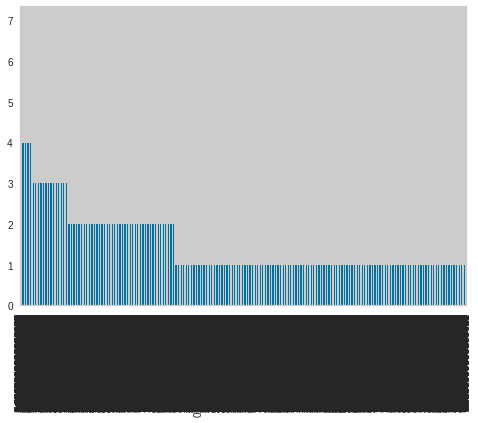

In [93]:
#Rating Distribution using bar chart
data["Label"].value_counts().plot(kind="bar")

In [96]:
print(data["Label"].min())
print(data["Label"].max())

0.243599995970726
5.898200035095215


**Filter Movies with less than 3 ratings**

In [97]:
filter_movies = data["movieId"].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()

**Filter Users with Less than 3 Movies Rates**

In [98]:
filter_Users = data["userId"].value_counts() > 3
filter_Users = filter_Users[filter_Users].index.tolist()

**Remove Rarely Movies and Rarely rating Users**

In [101]:
print(f"original shape of data: {data.shape}")
data = data[(data["movieId"].isin(filter_movies)) & (data["userId"].isin(filter_Users))]
print(f"New Shape: {data.shape}")

original shape of data: (20167, 3)
New Shape: (16412, 3)


**Importing the Surprise package from Scipy**

In [105]:
!pip install surprise

     |████████████████████████████████| 11.8MB 257kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670896 sha256=eca28a78d95cbc4561e2d930bbb81e052e1b9e37379c166c1c7746bf924ac1da
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [107]:
from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

**Create Surprise Dataset**

In [108]:
reader = Reader(rating_scale= (0.25,5))
final_data = Dataset.load_from_df(data,reader)

**Create Train and Prediction Set**

In [110]:
trainset = final_data.build_full_trainset()
testset = trainset.build_anti_testset()

**Model Creation**

In [111]:
#Implementing the SVD model
algo = SVD(n_epochs=25, verbose=True)

In [112]:
cross_validate(algo, final_data, measures=["RMSE","MAE"],cv=5,verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

{'fit_time': (1.050696611404419,
  1.0646235942840576,
  1.1121368408203125,
  1.0504167079925537,
  1.0641682147979736),
 'test_mae': array([0.14048121, 0.1425069 , 0.14017967, 0.14611465, 0.14447652]),
 'test_rmse': array([0.21481542, 0.21979383, 0.20825314, 0.22107836, 0.21712509]),
 'test_time': (0.023383140563964844,
  0.023819923400878906,
  0.021109580993652344,
  0.022235870361328125,
  0.021390676498413086)}

**Predictions**

In [113]:
#Creating prediction using Test set
prediction = algo.test(testset)

In [116]:
#Printing the predictions
prediction[0]

Prediction(uid=380, iid=36527, r_ui=3.564881818146131, est=3.862643364259959, details={'was_impossible': False})

From the above results, we can come to know that user is 380 and item id is 36527, and the actual rating is 3.564 and estimated(predicted) = 3.86

**Recommending Top 10 Movies based on Predictions**

In [119]:
from collections import defaultdict
#Creating a function
def get_top_n(prediction,n):
  top_n = defaultdict(list)
  for uid, iid, _, est, _ in prediction:
    top_n[uid].append((iid,est))

  for uid, user_ratings in top_n.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_n[uid] = user_ratings[:n]
  return top_n
  pass
top_n = get_top_n(prediction, n=10)
for uid, user_ratings in top_n.items():
  print(uid, [iid for (iid, rating) in user_ratings])
  #Here, 380 will the user id and the items inside the list are movieid

380 [177593, 48516, 56782, 112552, 44555, 142488, 55276, 105504, 104879, 55118]
382 [177593, 57669, 48516, 56782, 93838, 98491, 104879, 112552, 167746, 54997]
387 [177593, 58559, 168252, 104879, 68157, 112552, 79132, 134130, 91529, 78499]
414 [104879, 86377, 81847, 167746, 44555, 93838, 83803, 115569, 64716, 62336]
438 [177593, 167746, 112552, 58559, 57669, 99114, 170705, 81845, 56782, 97304]
480 [177593, 56782, 44555, 58559, 68157, 57669, 112552, 104879, 79132, 134130]
560 [177593, 88163, 168252, 56782, 78499, 104879, 105504, 98961, 44555, 98491]
599 [177593, 57669, 54997, 105504, 104879, 81847, 44555, 88810, 65261, 115569]
610 [177593, 112552, 98491, 167746, 83803, 81847, 48738, 65261, 64614, 73323]
143 [48516, 177593, 58559, 105504, 69481, 57669, 44199, 56782, 148626, 68157]
232 [177593, 104879, 112552, 62336, 106100, 115569, 55118, 88163, 44555, 81845]
274 [177593, 112552, 57669, 38061, 104879, 105504, 44555, 62336, 167746, 168252]
298 [177593, 168252, 54997, 104879, 56782, 142488,